<a href="https://colab.research.google.com/github/nguyenhaphan1/StockPricePredictionWithLSTM/blob/main/StockPriceFluctuationCalculating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Kết nối colab với ggdrive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import math
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow import keras
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

# 1. **Data preparing and processing** 😧  A. FPT quantitative trading record

In [ ]:
%cd "/content/drive/MyDrive/QuantPredict"
# Read data and view five head rows
df = pd.read_csv('FPT.csv')
df.head()

/content/drive/MyDrive/QuantPredict


,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ticker         97406 non-null  object 
 1   Date/Time      97406 non-null  object 
 2   Open           97406 non-null  float64
 3   High           97406 non-null  float64
 4   Low            97406 non-null  float64
 5   Close          97406 non-null  float64
 6   Volume         97406 non-null  int64  
 7   Open Interest  97406 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 5.9+ MB


In [ ]:
df_quant = pd.DataFrame(df, columns = ['Date/Time', 'Close']) # Sử dụng 2 attributes là Date/Time và Close price để tính
df_quant.index = df_quant['Date/Time'] # Chuyển Date/Time thành index cho dễ thao tác hơn
df_quant = df_quant.drop(['Date/Time'], axis=1)
df_quant.head()

,Close
Date/Time,
12/25/2018 9:15,30.89
12/25/2018 9:16,30.81
12/25/2018 9:17,30.74
12/25/2018 9:18,30.74
12/25/2018 9:19,30.74


In [ ]:
np_quant = df_quant.to_numpy() # Chuyển cột Close thành dạng numpy để tiến hành tạo input và output
X = []
y = []
for i in range(len(np_quant) - 30): # Sử dụng mô hình LSTM và sẽ lấy 30 giá trị liên tiếp để dự đoán giá trị thứ 31
    x_row = [a for a in np_quant[i:i+30]]
    label = np_quant[i+30]
    X.append(x_row)
    y.append(label)
X = np.array(X).reshape(len(X), -1)
y = np.array(y).reshape(len(y), -1)
print(X.shape)
print(y.shape)

(97376, 30)
(97376, 1)


In [ ]:
#Chuẩn hóa dữ liệu cho mô hình train nhanh và chính xác hơn
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()

x_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

In [ ]:
x_scaled.shape

(97376, 30)

In [ ]:
# Tiến hành chia input và output thành 3 tập data train / validation / test
train_size = int(len(x_scaled) * 0.6) #Vì khối lượng dữ liệu khá nhiều ~100.000 nên em chia theo tỉ lệ 6:2:2
test_size = int(len(y_scaled) * 0.2)
x_train, y_train = np.array(x_scaled[:train_size]), np.array(y_scaled[:train_size])
x_val, y_val = np.array(x_scaled[train_size:len(x_scaled) - test_size]), np.array(y_scaled[train_size:len(y_scaled) - test_size])
x_test, y_test = np.array(x_scaled[train_size + test_size:]), np.array(y_scaled[train_size + test_size:])

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(58227, 30)
(19740, 30)
(19740, 30)
(58227, 1)
(19740, 1)
(19740, 1)


# ***2. Model constructing and training ***

In [ ]:
model = Sequential()
#Xây dựng mô hình LSTM đơn giản với 3 layers LSTM
model.add(LSTM(units=64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(units=1))


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 64)            16896     
                                                                 
 dropout_3 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 30, 60)            30000     
                                                                 
 dropout_4 (Dropout)         (None, 30, 60)            0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                32000     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [ ]:
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta = 0.01) # EarlyStopping
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[keras.metrics.RootMeanSquaredError()])
model.fit(x_train, y_train, epochs=10, batch_size=128, callbacks=[callback], validation_data=(x_val, y_val)) #Fit model với tập train và val

Epoch 1/10
455/455 [==============================] - 82s 167ms/step - loss: 0.0036 - root_mean_squared_error: 0.0600 - val_loss: 2.2076e-04 - val_root_mean_squared_error: 0.0149
Epoch 2/10
455/455 [==============================] - 75s 164ms/step - loss: 0.0010 - root_mean_squared_error: 0.0321 - val_loss: 6.4286e-05 - val_root_mean_squared_error: 0.0080


In [ ]:
model.save("/content/drive/MyDrive/QuantPredict/best.h5")  # Lưu model

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
loaded_model = keras.models.load_model("/content/drive/MyDrive/QuantPredict/best.h5") # load model đã lưu trước đó để sử dụng

# **3. Evaluating**

In [ ]:
predict = loaded_model.predict(x_test) # Tiến hành dự đoán trên tập X_test
predict = y_scaler.inverse_transform(predict)

617/617 [==============================] - 10s 15ms/step


In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, predict))  # Đánh giá RMSE của giá trị predict và thực tế
rmse

51.46575573354591

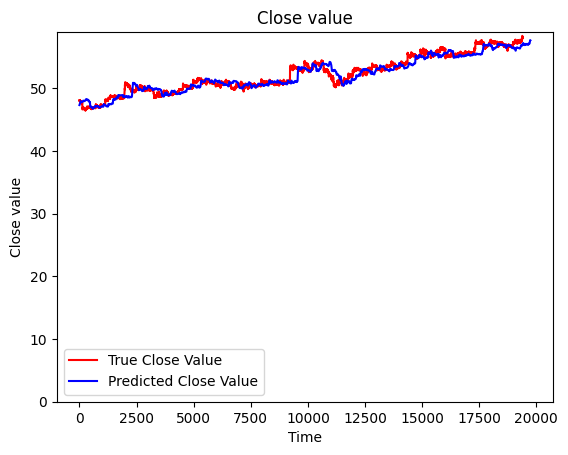

In [ ]:
#Plot giá trị dự đoán và giá trị thực tế ra đồ thị cho trực quan về dễ đánh giá
y_true = np.array(df_quant[len(df_quant)-test_size:].values)

plt.plot(y_true, color="red", label="True Close Value")
plt.plot(predict, color="blue", label="Predicted Close Value")
plt.title("Close value")
plt.xlabel("Time")
plt.ylabel("Close value")
plt.ylim(bottom=0)
plt.legend()
plt.show()

# **4. Calculating stock price fluctuation**


In [ ]:
#Tính thời gian bắt đầu và kết thúc trong 1 ngày của sàn giao dịch
open_time = pd.to_datetime(df_quant.index).time.min()
close_time = pd.to_datetime(df_quant.index).time.max()
print(open_time)
print(close_time)

09:15:00
14:46:00


In [ ]:
# Hàm chuẩn bị dữ liệu cho dự đoán

def create_custom_time_index(start_date, end_date): #Vì thời gian chỉ chạy trong khoảng 9:15 -> 14:46
    full_time_index = pd.DatetimeIndex([])

    # Tạo chuỗi thời gian cho mỗi ngày
    for single_date in pd.date_range(start=start_date.date(), end=end_date):
        start_datetime = pd.to_datetime(f"{single_date.date()} {'09:15'}")
        end_datetime = pd.to_datetime(f"{single_date.date()} {'14:46'}")
        time_range = pd.date_range(start=start_datetime, end=end_datetime, freq='T')
        filtered_time_range = time_range[(time_range > pd.to_datetime(start_date)) & (time_range <= pd.to_datetime(end_date))]
        full_time_index = full_time_index.append(filtered_time_range)

    return full_time_index

def prepare_data(data, n_steps=30):
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    data_scaled = data_scaled.reshape(-1, len(data_scaled))
    return data_scaled, scaler

# Dự đoán liên tiếp
def predict_future(input_end_date, df, model=None, nstep=30, filename=None):
    lastN = df.to_numpy()[-nstep:] # N kết quả cuối cùng của dữ liệu
    last_date = pd.to_datetime(lastN[-1][0]) #Mốc thời gian cuối cùng của dữ liệu
    full_time_index = create_custom_time_index(last_date,
                                           input_end_date)
    if str(input_end_date) in df['Date/Time'].values:
        return df[df['Date/Time'] == str(input_end_date)]['Close'].values[0]
    for date in full_time_index:
        data = lastN[-nstep:, 1].reshape(nstep, -1)
        X, scaler = prepare_data(data, nstep)
        predictions = []
        prediction = model.predict(X)
        prediction = scaler.inverse_transform(prediction).flatten()
        lastN = np.vstack([lastN, np.array([date, prediction[0]])])
    # Lưu dữ liệu dự đoán được vào file csv để lần sau không cần dự đoán lại những khoảng thời gian này nữa
    new_df = pd.DataFrame(lastN, columns=['Date/Time', 'Close'])
    new_df['Date/Time'] = pd.to_datetime(new_df['Date/Time'])
    df = pd.concat([df, new_df[nstep:]], ignore_index=True)
    df.to_csv(os.path.join('/content/drive/MyDrive/QuantPredict', filename+'.csv'), index=False)
    return prediction

In [ ]:
from datetime import datetime #Hàm nhập input theo format

def datetime_format_input(mes):
  while True:
    try:
        input_str = input(mes)

        datetime_format = "%m/%d/%Y %H:%M"

        dt = datetime.strptime(input_str, datetime_format)

        return dt
    except ValueError:
        print(f"Input của bạn '{input_str}' không đúng với format hoặc là thời \
gian không tồn tại (MM/DD/YYYY HH\:MM), mời nhập lại \n Ví dụ (03/12/2021)")


In [ ]:
# Đọc dữ liệu
predict_df = pd.read_csv('/content/drive/MyDrive/QuantPredict/predict.csv')
# Xác định ngày bắt đầu và ngày kết thúc nhập vào
while True:
    try:
        input_today_date = datetime_format_input("Nhập thời gian đầu tiên bạn muốn tính giá chứng khoán (MM/DD/YYYY HH:MM): ")
        input_end_date = datetime_format_input("Nhập thời gian thứ hai bạn muốn tính giá chứng khoán (MM/DD/YYYY HH:MM): ")
        if input_today_date > input_end_date:
            raise Exception("Thời gian thứ hai phải lớn hơn thời gian ban đầu")
        else:
          break
    except:
        print("Nhập lại. Thời gian thứ hai phải lớn hơn thời gian ban đầu")
loaded_model = keras.models.load_model("/content/drive/MyDrive/QuantPredict/best.h5")
today_predict = predict_future(input_today_date, predict_df, loaded_model, nstep=30, filename='predict')
end_date_predict = predict_future(input_end_date, predict_df, loaded_model, nstep=30, filename='predict')
print("Giá cổ phiếu N là: ", today_predict)
print("Giá cổ phiếu hiện tại là: ", end_date_predict)
print("Biến động giá cổ phiếu = giá cổ phiếu N - Giá cổ phiếu hiện tại = ", end_date_predict - today_predict)
#12/23/2020 10:05

Nhập thời gian đầu tiên bạn muốn tính giá chứng khoán (MM/DD/YYYY HH:MM): 12/23/2020 13:00
Nhập thời gian thứ hai bạn muốn tính giá chứng khoán (MM/DD/YYYY HH:MM): 12/23/2020 13:20
[['2020-12-23 12:21:00' 58.149815]
 ['2020-12-23 12:22:00' 58.149815]
 ['2020-12-23 12:23:00' 58.149815]
 ['2020-12-23 12:24:00' 58.149815]
 ['2020-12-23 12:25:00' 58.149815]
 ['2020-12-23 12:26:00' 58.149815]
 ['2020-12-23 12:27:00' 58.149815]
 ['2020-12-23 12:28:00' 58.149815]
 ['2020-12-23 12:29:00' 58.149815]
 ['2020-12-23 12:30:00' 58.149815]
 ['2020-12-23 12:31:00' 58.149815]
 ['2020-12-23 12:32:00' 58.149815]
 ['2020-12-23 12:33:00' 58.149815]
 ['2020-12-23 12:34:00' 58.149815]
 ['2020-12-23 12:35:00' 58.149815]
 ['2020-12-23 12:36:00' 58.149815]
 ['2020-12-23 12:37:00' 58.149815]
 ['2020-12-23 12:38:00' 58.149815]
 ['2020-12-23 12:39:00' 58.149815]
 ['2020-12-23 12:40:00' 58.149815]
 ['2020-12-23 12:41:00' 58.14981]
 ['2020-12-23 12:42:00' 58.14981]
 ['2020-12-23 12:43:00' 58.149815]
 ['2020-12-23 12